# The 2D Ising model

As an example for a magnetic material we will simulate the **2D Ising model**. We will use a Markov Chain Monte Carlo approach with Metropolis sampling to simulate configurations of the chain at a temperature $T$.

$$
H = -\epsilon \sum_{(i,j)} s_i s_j
$$

The interaction is over nearest neighbors $(i,j)$ only.

In [1]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
plt.matplotlib.style.use('ggplot')

import tqdm

rng = np.random.default_rng(seed=20220428)

In [29]:
class SpinLattice:
    def __init__(self, N, kT=1.0, p=0.5):
        """Set up 2D lattice with NxN spins, fraction p flipped down"""
        self.N = N
        self.Nspins = N*N
        self.kT = kT
        self.beta = 1/self.kT
        # initialize by flipping a spin to down with probability p
        self.spins = np.where(rng.uniform(size=(N, N)) <= p, -1, 1)
        self.E = None
        self.M = None
        
    def energy_slow(self):
        """total energy in units of epsilon for given spin microstate
        
        (Slow implementation with explicit loops for pedagogical purposes.)
        """
        s = model.spins
        E = 0
        for i in range(self.N):
            for j in range(self.N):
                # PBC taken into account with i-1 and (i+1) % N
                E -= s[i, j] * (s[i-1, j] + s[(i+1) % self.N, j]
                                  + s[i, j-1] + s[i, (j+1) % self.N])
        E /= 2   # double counting of interactions
        return E
        
    def energy(self):
        """total energy in units of epsilon for current spin microstate"""
        # This faster implementation with numpy array operations is about 40 times
        # faster than energy_slow() for a 32x32 model
        
        # Add the periodic neighbors at the boundaries (augment boundaries) in
        # a temporary bigger spin array of size (N+2) x (N+2):
        s = np.zeros((self.N+2, self.N+2), dtype=int)
        s[1:-1, 1:-1] = self.spins
        s[0] = s[-2]             # periodic boundary conditions: left
        s[-1] = s[1]             # pbc: right
        s[:, 0] = s[:, -2]       # pbc: bottom
        s[:, -1] = s[:, 1]       # pbc: top
        
        # 1/2 because double counting
        E = -0.5 * np.sum(s[1:-1, 1:-1] * 
                   (s[:-2, 1:-1] + s[2:, 1:-1] + s[1:-1, :-2] + s[1:-1, 2:]))   
        return E
    
    def magnetization(self):
        return float(np.sum(self.spins))
    
    def _update(self, i, j, randfloat):
        """Update of a single spin i, j with Metropolis criterion.
        
        Generate a random-uniform float 0 <= x < 1 for Metropolis in advance.
        """
        
        s = self.spins
        
        accept = False
        dE = 2 * s[i, j] * (s[i-1, j] + s[(i+1) % self.N, j]
                          + s[i, j-1] + s[i, (j+1) % self.N])  # with periodic boundary conditions
        if dE <= 0:
            accept = True
        else:
            p = np.exp(-self.beta * dE)
            accept = (randfloat < p)
            
        if accept:
            s[i, j] *= -1
        
        return accept
    
    def run(self, iterations=1000, verbose=True):
        """Run `iterations` sweeps of updates.
                
        Parameters
        ----------
        iterations : int
            Each iteration performs N**2 trial spin flip moves.
            The total number of MC moves is iterations * N**2.
        verbose : bool
            switches on a progress bar with timing information
            
        Returns
        -------
        E : float
            energy of the configuration, also stored as :attr:`E`
        M : float
            magnetization of the configuration, also stored as :attr:`M`
        ratio : float
            acceptance ratio for trials, N_accepted/N_total
        """
        
        energies = []
        magnetizations = []
        n_accept = 0
        for iteration in tqdm.tqdm(range(iterations), disable=not verbose):
            for (i, j), x in zip(rng.integers(low=0, high=self.N, dtype=int, size=(self.Nspins, 2)),
                                 rng.uniform(size=self.Nspins)):
                accept = self._update(i, j, x)
                n_accept += accept
            energies.append(self.energy())
            magnetizations.append(self.magnetization())
            
        acceptance_ratio = n_accept / (self.Nspins * iterations)
        self.E = np.array(energies)
        self.M = np.array(magnetizations)
        
        return self.E, self.M, acceptance_ratio
    
    def average(self, a, burnin):
        start = int(round(burnin * len(a)))
        return np.average(a[start:])
    
    def E_average(self, burnin=0.1):
        """<E>/N (with initial burnin fraction removed)"""
        return self.average(self.E, burnin)/self.Nspins
    
    def M_average(self, burnin=0.1):
        """<M>/N (with initial burnin fraction removed)"""
        return self.average(self.M, burnin)/self.Nspins
    
    def plot(self, burnin=0.1):
        """Plot model.
        
        The 3-panel plot includes
        1. NxN grid of spins at the last step
        2. mean energy per spin as function of steps
        3. mean magnetization per spin as function of steps
        
        A "burn-in" period (expressed as the total fraction 
        of MC steps, `burnin`) can be discarded for the calculation of 
        the average energy and magnetization to avoid biasing results
        towards the initial state.
        """
        fig, axes = plt.subplots(1, 3, figsize=(10, 3))

        axes[0].set_title(r"$kT/\epsilon =$" f"{self.kT:.1f}")
        axes[0].grid(False)
        axes[0].pcolormesh(self.spins)
        axes[0].set_aspect("equal")

        # collect data after burnin period
        n_total = len(self.E)
        n_start = int(burnin * n_total)
        steps = np.arange(n_total)
        
        axes[1].set_title(r"$\langle E\rangle/N\epsilon =$" f"{self.E_average(burnin=burnin):.3f}")
        axes[1].plot(steps[:n_start], self.E[:n_start]/self.Nspins, color="r", alpha=0.3)
        axes[1].plot(steps[n_start:], self.E[n_start:]/self.Nspins, color="r", alpha=1)
        axes[1].set(xlabel=r"MC step", ylabel=r"$E/N\epsilon$");

        axes[2].set_title(r"$\langle M\rangle/N =$" f"{self.M_average(burnin=burnin):.3f}")
        axes[2].plot(steps[:n_start], self.M[:n_start]/self.Nspins, color="b", alpha=0.3)
        axes[2].plot(steps[n_start:], self.M[n_start:]/self.Nspins, color="b", alpha=1)
        axes[2].set(xlabel=r"MC step", ylabel=r"$M/N$")

        fig.tight_layout()
        
        return fig

def E_analytical(kT): # 2d
    # epsilon = 1
    beta = 1/kT
    m = 4 * np.sinh(2*beta)**2 / np.cosh(2*beta)**4
    return -2 * np.tanh(2*beta) - 2 * (np.sinh(2*beta)**2 - 1)/np.sinh(4*beta) * (
        2/np.pi * scipy.special.ellipk(m) - 1)
    
def M_analytical(kT, Tc=2/np.log(1 + np.sqrt(2))):
    below = kT < Tc
    beta = 1/kT
    M = np.zeros_like(kT)
    M[below] = (1 - np.sinh(2*beta[below])**(-4))**(1/8)
    return M

## Explore the 2D Ising model at different temperatures

We can easily run the `SpinLattice` model in a $32 \times 32$ configuration for two thousand iterations easily (i.e., $32^2 \times 2000 = 2.048 \times 10^6$ MC steps) to explore the behavior for a range of temperatures $1 \le kT/\epsilon \le 4$ (at low temperatures, the lattice only relaxes slowly to equilibrium with low acceptance probabilities and hence higher number of MC steps are needed). 

In order to improve our estimates for the mean quantitites, we discard 10% of the MC trajectory as initial relaxation phase, the so called "burn-in". Although this is not strictly necessary, it helps to improve accuracy for relatively short runs.

At the low temperature we also start the system with $p=0.2$ near an equilibrium configuration of the system (which would be $p=1$ or $p=0$) in order to accelerate relaxation to equilibrium. In principle this is not necessary but it speeds up the process, especially as we are limiting ourselves to relatively short MC runs.

In [48]:
model = SpinLattice(32, kT=1,  p=0.2)

E, M, r = model.run(iterations=2000)
print(r)
print(model.E_average(), model.M_average())

100%|██████████████████████████████████████| 2000/2000 [00:16<00:00, 119.21it/s]

0.0010234375
-1.9970876736111112 0.9992621527777777


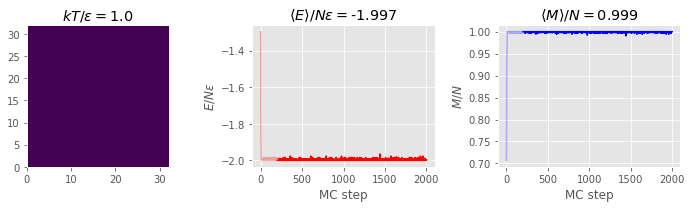

In [49]:
fig = model.plot()
fig.savefig("ising2d_kT1.0.png")

In [50]:
model = SpinLattice(32, kT=2.,  p=0.2)

E, M, r = model.run(iterations=2000)
print(r)
print(model.E_average(), model.M_average())

100%|██████████████████████████████████████| 2000/2000 [00:16<00:00, 121.12it/s]

0.07768603515625
-1.7503862847222222 0.9144498697916666


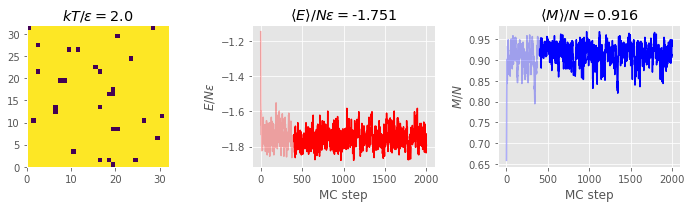

In [51]:
fig = model.plot(burnin=0.2)
fig.savefig("ising2d_kT2.0.png")

In [52]:
model = SpinLattice(32, kT=2.2,  p=0.5)

E, M, r = model.run(iterations=2000)
print(r)
print(model.E_average(), model.M_average())

100%|██████████████████████████████████████| 2000/2000 [00:16<00:00, 122.53it/s]

0.14857080078125
-1.5611480034722223 -0.8100010850694445


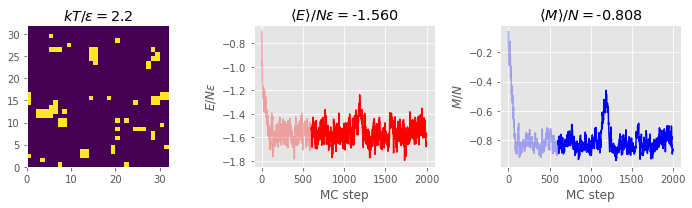

In [53]:
fig = model.plot(burnin=0.3)
fig.savefig("ising2d_kT2.2.png")

In [54]:
model = SpinLattice(32, kT=2.4,  p=0.5)

E, M, r = model.run(iterations=2000)
print(r)
print(model.E_average(), model.M_average())

100%|██████████████████████████████████████| 2000/2000 [00:15<00:00, 128.05it/s]

0.27343798828125
-1.231171875 0.073037109375


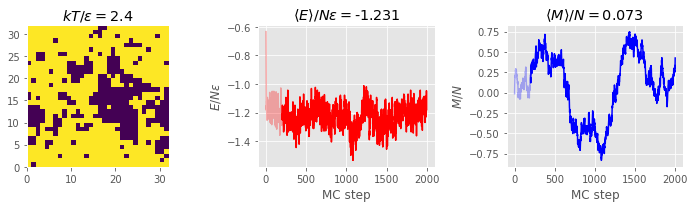

In [55]:
fig = model.plot()
fig.savefig("ising2d_kT2.4.png")

In [56]:
model = SpinLattice(32, kT=4)

E, M, r = model.run(iterations=2000)
print(r)
print(model.E_average(), model.M_average())

100%|██████████████████████████████████████| 2000/2000 [00:14<00:00, 137.80it/s]

0.6094931640625
-0.5565711805555555 0.003910590277777778


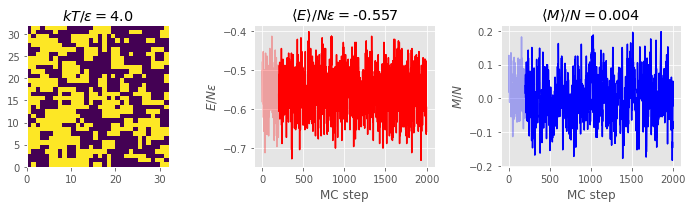

In [57]:
fig = model.plot()
fig.savefig("ising2d_kT4.0.png")

## Temperature dependence of $E$ and $M$

The dependence of the average energy per spin $\langle E \rangle/N$ on the temperature $T$ for the 2D spin lattice (Ising model) is

$$
\frac{\langle E \rangle}{N\epsilon} = -2\tanh 2\beta\epsilon -2 \frac{\sinh^2 2\beta\epsilon -1}{\sinh 4\beta\epsilon} \left(\frac{2}{\pi}K(m) -1 \right)
$$

with the parameter

$$
m = \frac{4 \sinh^2 2\beta\epsilon}{\cosh^4 2\beta\epsilon}. 
$$

The average magnetization per spin is

$$
\frac{\langle M \rangle}{N} = \begin{cases}
(1 - \sinh^{-4} 2\beta\epsilon)^{1/8}, \quad T < T_c\\
0, \quad T \ge Tc
\end{cases}
$$

with the critical temperature 

$$
\frac{k T_c}{\epsilon} = \frac{2}{\ln\big(1 + \sqrt{2}\big)} \approx 2.2692
$$ 
at which the phase transition occurs.


Run the simulation for a range of temperatures (measured in $kT$); note that we speed up the initial equilibration phase by setting the average spin distribution close to the expected equilibrium value by tuning the parameter `p`. The exact value of `p` is not important and the correct observables should be obtained independent of `p`, just the required number of `iterations` may increase.

In [43]:
Tc = 2/np.log(1 + np.sqrt(2))

temperatures = np.linspace(0.1, 5, 50)

Nspins = 32
energy = np.zeros_like(temperatures)
magnetization = np.zeros_like(temperatures)

for j, kT in tqdm.tqdm(enumerate(temperatures), total=len(temperatures)):
    p = 0.05 if kT < Tc else 0.5
    model = SpinLattice(Nspins, kT=kT, p=p)
    model.run(iterations=1000, verbose=False)
    energy[j] = model.E_average()
    magnetization[j] = model.M_average()


100%|███████████████████████████████████████████| 50/50 [05:02<00:00,  6.06s/it]


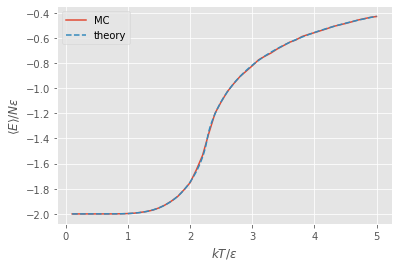

In [46]:
kT = np.linspace(0.1, 5, 200)

plt.plot(temperatures, energy, label="MC")
plt.plot(kT, E_analytical(kT), '--', label="theory")
plt.xlabel(r"$kT/\epsilon$")
plt.ylabel(r"$\langle E\rangle/N\epsilon$")
plt.legend()

plt.savefig("ising2d_energy_temperature.png")

The exact energy from the theoretical solution is reproduced well by the MCMC simulation. The phase transition manifests as a slight kink in the energy graph but this is barely visible in the analytic solution. One should calculate the heat capacity $C = \partial\langle E \rangle/\partial T$ and look for the peak in $C(T)$.

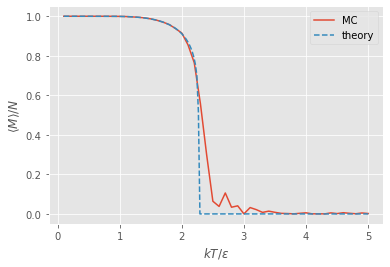

In [47]:
plt.plot(temperatures, np.abs(magnetization), label="MC")
plt.plot(kT, M_analytical(kT), "--", label="theory")
plt.xlabel(r"$kT/\epsilon$")
plt.ylabel(r"$\langle M \rangle/N$")
plt.legend()

plt.savefig("ising2d_magnetization_temperature.png")

The phase transition is more clearly visible in the average magnetization, especially in the analytical solution. For $T < T_c$, the lattice has a non zero magnetization (in the absence of external fields). Above the critical temperature the magnetization is zero because the thermal motion of the spins overcomes that coupling between spins. The region near the transition temperature is difficult to sample accurately but the overall presence of the phase transition is clearly visible.